# Spotify 2024 — EDA & Modeling

This notebook performs a complete analysis of the Most Streamed Spotify Songs (2024): loading, cleaning, exploratory analysis (EDA), correlations, clustering (KMeans) and regression modeling (baseline + Random Forest).

In [227]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import faiss
import umap
import hdbscan
import warnings

In [228]:
# Download latest version from Kagglehub
path = kagglehub.dataset_download("nelgiriyewithana/most-streamed-spotify-songs-2024")
print("Dataset downloaded to:", path)
print("Files:", os.listdir(path))

Dataset downloaded to: /Users/klaudia/.cache/kagglehub/datasets/nelgiriyewithana/most-streamed-spotify-songs-2024/versions/1
Files: ['Most Streamed Spotify Songs 2024.csv']


In [229]:
file_path = os.path.join(path, "Most Streamed Spotify Songs 2024.csv")

In [230]:
df = pd.read_csv(csv_path, encoding='latin1')

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Track                       4600 non-null   object 
 1   Album Name                  4600 non-null   object 
 2   Artist                      4595 non-null   object 
 3   Release Date                4600 non-null   object 
 4   ISRC                        4600 non-null   object 
 5   All Time Rank               4600 non-null   object 
 6   Track Score                 4600 non-null   float64
 7   Spotify Streams             4487 non-null   object 
 8   Spotify Playlist Count      4530 non-null   object 
 9   Spotify Playlist Reach      4528 non-null   object 
 10  Spotify Popularity          3796 non-null   float64
 11  YouTube Views               4292 non-null   object 
 12  YouTube Likes               4285 non-null   object 
 13  TikTok Posts                3427 

In [232]:
df.describe()

,Track Score,Spotify Popularity,Apple Music Playlist Count,Deezer Playlist Count,Amazon Playlist Count,TIDAL Popularity,Explicit Track
count,4600.000000,3796.000000,4039.00000,3679.000000,3545.000000,0.0,4600.000000
mean,41.844043,63.501581,54.60312,32.310954,25.348942,NaN,0.358913
std,38.543766,16.186438,71.61227,54.274538,25.989826,NaN,0.479734
min,19.400000,1.000000,1.00000,1.000000,1.000000,NaN,0.000000
25%,23.300000,61.000000,10.00000,5.000000,8.000000,NaN,0.000000
50%,29.900000,67.000000,28.00000,15.000000,17.000000,NaN,0.000000
75%,44.425000,73.000000,70.00000,37.000000,34.000000,NaN,1.000000
max,725.400000,96.000000,859.00000,632.000000,210.000000,NaN,1.000000


In [233]:
df.head(5)

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1


In [234]:
df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index': 'Track', 0: 'Missing Values'}) #Missing values per column
df_missing.drop(index=df.index[0], axis=0, inplace=True)
df_missing[df_missing['Missing Values']>0].sort_values(by='Missing Values', ascending=False)

,Track,Missing Values
27,TIDAL Popularity,4600
25,Soundcloud Streams,3333
19,SiriusXM Spins,2123
24,Pandora Track Stations,1268
13,TikTok Posts,1173
23,Pandora Streams,1106
22,Amazon Playlist Count,1055
16,YouTube Playlist Reach,1009
15,TikTok Views,981
14,TikTok Likes,980


In [235]:
df.drop('TIDAL Popularity', axis=1, inplace=True)

In [236]:
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].fillna(0)
df['Spotify Playlist Count'].isnull().sum()

np.int64(0)

#### Data types
Convert numeric-like text columns to numeric

In [237]:
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].fillna(0)
df['Spotify Playlist Count'].isnull().sum()

np.int64(0)

In [238]:
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].apply(lambda x: str(x).replace(',', ''))
df['Spotify Playlist Count']

0        30716
1        28113
2        54331
3       269802
4         7223
         ...  
4595     65770
4596      4602
4597     72066
4598     14037
4599     32138
Name: Spotify Playlist Count, Length: 4600, dtype: object

#### Duplicates

In [239]:
df_duplicates = pd.DataFrame(df.duplicated()).rename(columns={0: 'duplicate'})
df_duplicates[df_duplicates['duplicate'] == True]

,duplicate
2450,True
3450,True


In [240]:
dups = df[df.duplicated(keep=False)]
dups

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,Explicit Track
2449,Tennessee Orange,Tennessee Orange,Megan Moroney,9/2/2022,TCAGJ2289254,"2,424",28.9,"227,893,586",28139,"12,480,714",...,"129,172",34,5.0,"1,370",49.0,"56,972,562","26,968","1,336,043","708,143",0
2450,Tennessee Orange,Tennessee Orange,Megan Moroney,9/2/2022,TCAGJ2289254,"2,424",28.9,"227,893,586",28139,"12,480,714",...,"129,172",34,5.0,"1,370",49.0,"56,972,562","26,968","1,336,043","708,143",0
3447,Dembow,Dembow,Danny Ocean,12/8/2017,USWL11700269,"3,441",23.3,"579,189,526",60397,"11,805,084",...,"5,406",9,20.0,"37,649",12.0,"6,723,858","7,832",NaN,"1,619,550",0
3450,Dembow,Dembow,Danny Ocean,12/8/2017,USWL11700269,"3,441",23.3,"579,189,526",60397,"11,805,084",...,"5,406",9,20.0,"37,649",12.0,"6,723,858","7,832",NaN,"1,619,550",0


In [241]:
df = df.drop_duplicates()

#### EDA - distributions & top artist

In [242]:
streams_num = (df["Spotify Streams"].astype(str).str.replace(r"[^\d.]", "", regex=True).replace("", np.nan).astype(float))

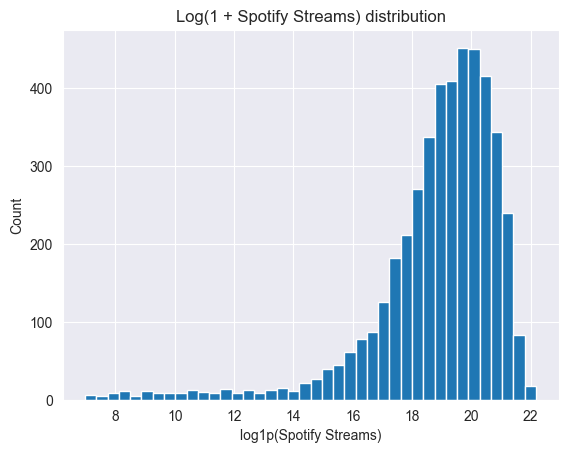

In [243]:
vals = streams_num.dropna()
plt.figure()
plt.hist(np.log1p(vals), bins=40)
plt.title("Log(1 + Spotify Streams) distribution")
plt.xlabel("log1p(Spotify Streams)")
plt.ylabel("Count")
plt.show()

The histogram presents the distribution of Spotify track streams after applying a logarithmic log1p transformation. This transform is used to reduce strong right-skewness in the data.
The noticeable long right tail highlights the presence of a highly successful minority that captures a disproportionate share of total streams.

In [244]:
artists_clean = (df["Artist"].astype(str).str.strip().replace("", np.nan).fillna("Unknown"))

In [245]:
artists_split = (artists_clean.str.replace("feat.", ",", regex=False)
                            .str.replace("&", ",", regex=False)
                            .str.replace(" and ", ",", regex=False, case=False)
                            .str.split(",")
                            .explode()
                            .str.strip())

In [246]:
top_artists = artists_split.value_counts().head(15)
top_artists

Artist
Taylor Swift      63
Drake             63
Bad Bunny         60
KAROL G           32
The Weeknd        31
Travis Scott      30
Billie Eilish     27
Ariana Grande     26
Future            23
Post Malone       22
Peso Pluma        22
Juice WRLD        21
Morgan Wallen     20
Olivia Rodrigo    20
Lil Baby          20
Name: count, dtype: int64

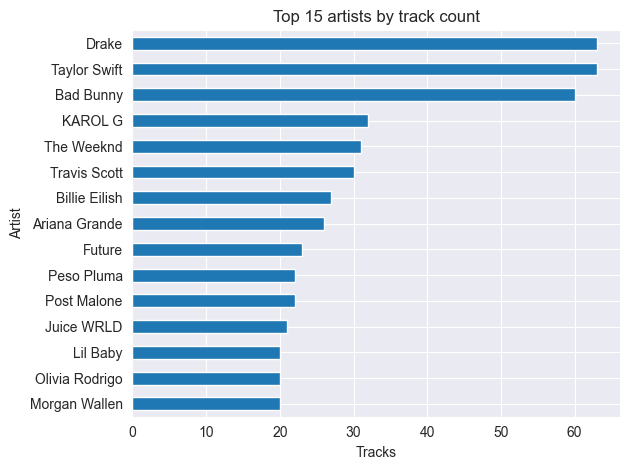

In [247]:
plt.figure()
top_artists.sort_values().plot(kind="barh")
plt.title("Top 15 artists by track count")
plt.xlabel("Tracks")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()

In [248]:
df["Release Year"] = pd.to_datetime(df["Release Date"], errors="coerce").dt.year
temp = df.dropna(subset=["Spotify Popularity", "Release Year"])
year_pop = (temp.groupby("Release Year")["Spotify Popularity"].mean().sort_index())

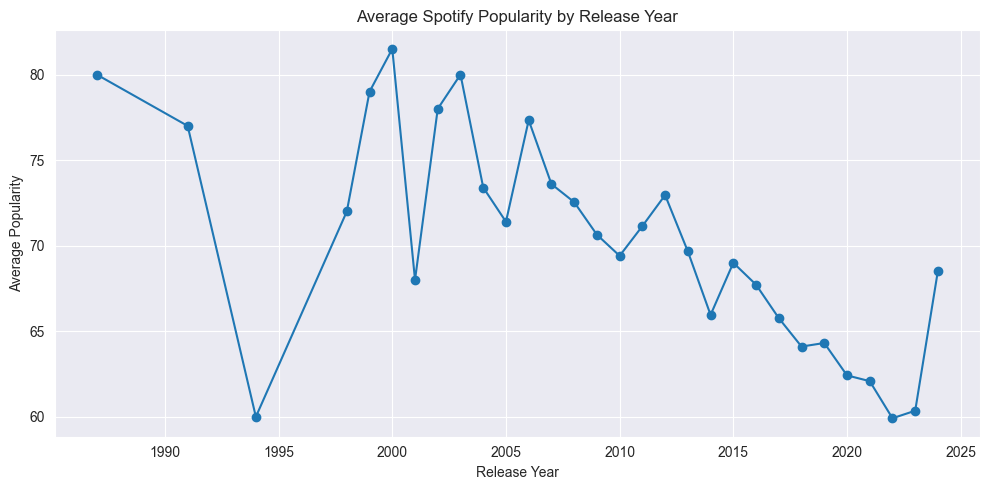

In [249]:
plt.figure(figsize=(10, 5))
plt.plot(year_pop.index, year_pop.values, marker="o")
plt.title("Average Spotify Popularity by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Average Popularity")
plt.grid(True)
plt.tight_layout()
plt.show()

In [250]:
explicit_share = df["Explicit Track"].mean()
print(f"Explicit share (1=explicit): {explicit_share:.2%}")

Explicit share (1=explicit): 35.91%


The average popularity of tracks varies significantly across release years, indicating the influence of short-term music trends.
The highest popularity averages occur around 1999–2003 - timeless mainstream hits and the rise of digital music.
The lowest values appear for 2020–2023 releases.

~36% of tracks in the dataset are labeled Explicit.

Popularity distribution reflects also cultural shifts, algorithmic dynamics and the competitive streaming environment.

#### Identify outliers

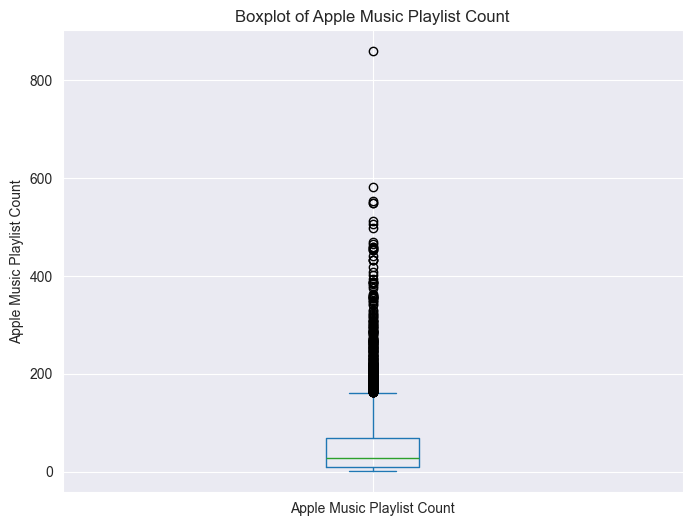

In [251]:
plt.figure(figsize=(8, 6))
df['Apple Music Playlist Count'].plot(kind='box')
plt.title('Boxplot of Apple Music Playlist Count')
plt.ylabel('Apple Music Playlist Count')
plt.show()

Most tracks appear in only a few Apple Music playlists, while a small subset is featured in hundreds of playlists. This confirms the highly uneven distribution of streaming exposure.

#### Cross-platform correlations

In [252]:
candidate_metrics = [
    "Spotify Streams", "Spotify Playlist Count", "Spotify Playlist Reach", "Spotify Popularity",
    "YouTube Views", "YouTube Likes",
    "TikTok Posts", "TikTok Likes", "TikTok Views",
    "Apple Music Playlist Count",
    "AirPlay Spins", "SiriusXM Spins",
    "Deezer Playlist Count", "Deezer Playlist Reach",
    "Amazon Playlist Count",
    "Pandora Streams", "Pandora Track Stations",
    "Soundcloud Streams",
    "Shazam Counts",
    "Track Score"]

In [253]:
metrics = [c for c in candidate_metrics if c in df.columns]
df_clean = df[metrics].apply(pd.to_numeric, errors='coerce') #fix
corr = df_clean.corr()

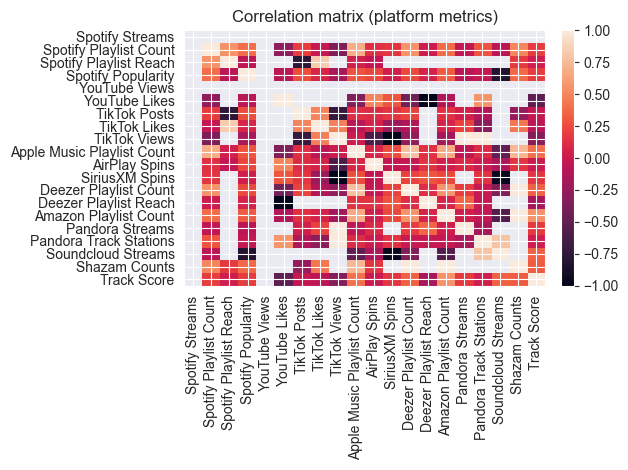

In [254]:
plt.figure()
im = plt.imshow(corr, aspect="auto")
plt.title("Correlation matrix (platform metrics)")
plt.xticks(range(len(metrics)), metrics, rotation=90)
plt.yticks(range(len(metrics)), metrics)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

Music popularity is multi-platform, but Spotify and YouTube remain the most influential in determining streaming success.

#### Data format

### TikTok and Spotify

In [255]:
tv = pd.to_numeric(df["TikTok Views"].astype(str).str.replace(r"[^\d.]", "", regex=True), errors="coerce")
ss = pd.to_numeric(df["Spotify Streams"].astype(str).str.replace(r"[^\d.]", "", regex=True), errors="coerce")

In [256]:
m = tv.notna() & ss.notna()
X = tv[m].to_numpy().reshape(-1, 1)
y = ss[m].to_numpy()

In [257]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [258]:
print(f"R²: {model.score(X, y):.3f}")
print(f"coef: {model.coef_[0]:.4f}, intercept: {model.intercept_:.2f}")

R²: 0.001
coef: 0.0028, intercept: 496490416.87


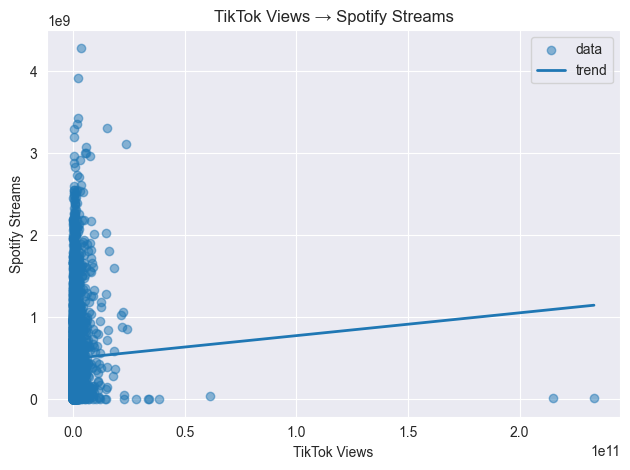

In [259]:
plt.figure()
plt.scatter(X, y, alpha=0.5, label="data")
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
plt.plot(x_line, model.predict(x_line), linewidth=2, label="trend")
plt.xlabel("TikTok Views")
plt.ylabel("Spotify Streams")
plt.title("TikTok Views → Spotify Streams")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

A few tracks achieve massive exposure on TikTok. Most tracks have very low view counts and these do not translate into higher Spotify streams.
The relationship is non-linear, so a linear regression model fails to capture the true effect.
TikTok can strongly boost streaming performance, but only for a small subset of highly viral songs.

In [260]:
#log transformation
tv_log = np.log1p(tv)
ss_log = np.log1p(ss)

In [261]:
mask = tv_log.notna() & ss_log.notna()
X = tv_log[mask].values.reshape(-1, 1)
y = ss_log[mask].values

In [262]:
model = LinearRegression().fit(X, y)

In [263]:
print(f"R²: {model.score(X, y):.3f}")
print(f"Coefficient: {model.coef_[0]:.3f}")
print(f"Intercept: {model.intercept_:.3f}")

R²: 0.076
Coefficient: 0.182
Intercept: 15.801


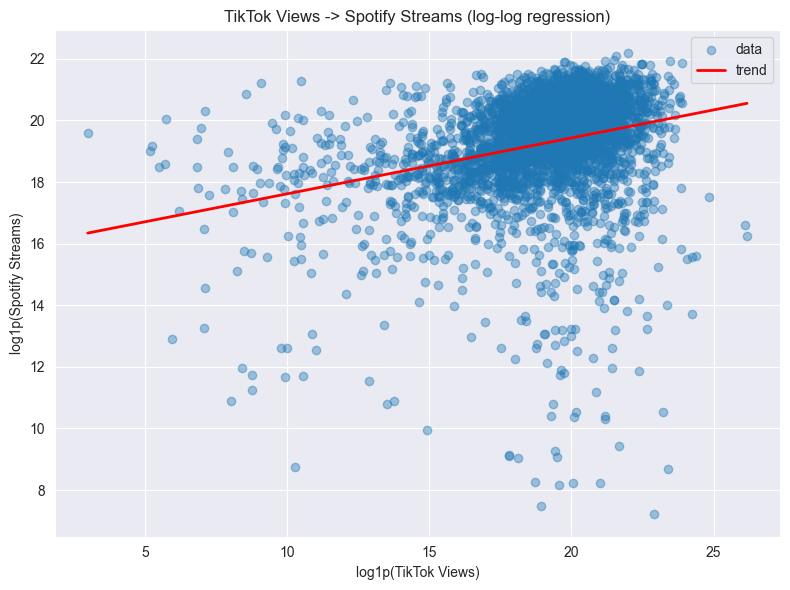

In [264]:
plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.4, label="data")
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
plt.plot(x_line, model.predict(x_line), color="red", linewidth=2, label="trend")
plt.xlabel("log1p(TikTok Views)")
plt.ylabel("log1p(Spotify Streams)")
plt.title("TikTok Views -> Spotify Streams (log-log regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

After applying a logarithmic transformation, a clear positive correlation emerges between TikTok view counts and Spotify stream counts.
Viral success on TikTok is an important predictor of Spotify performance, but it is not sufficient on its own.

In [265]:
spc = pd.to_numeric(df["Spotify Playlist Count"].astype(str).str.replace(r"[^\d.]", "", regex=True), errors="coerce")

In [266]:
X1 = np.log1p(tv)
X2 = np.log1p(spc)
y  = np.log1p(ss)

In [267]:
m = X1.notna() & X2.notna() & y.notna()
X1 = X1[m].values.reshape(-1, 1)
X2 = X2[m].values.reshape(-1, 1)
y  = y[m]

In [268]:
# Model 1 - TikTok -> Streams
model1 = LinearRegression().fit(X1, y)
print(f"R² TikTok only: {model1.score(X1, y):.3f}")

R² TikTok only: 0.076


In [269]:
# Model 2 - TikTok + Playlists -> Streams
X = np.hstack([X1, X2])
model2 = LinearRegression().fit(X, y)
print(f"R² TikTok + Playlists: {model2.score(X, y):.3f}")

R² TikTok + Playlists: 0.859


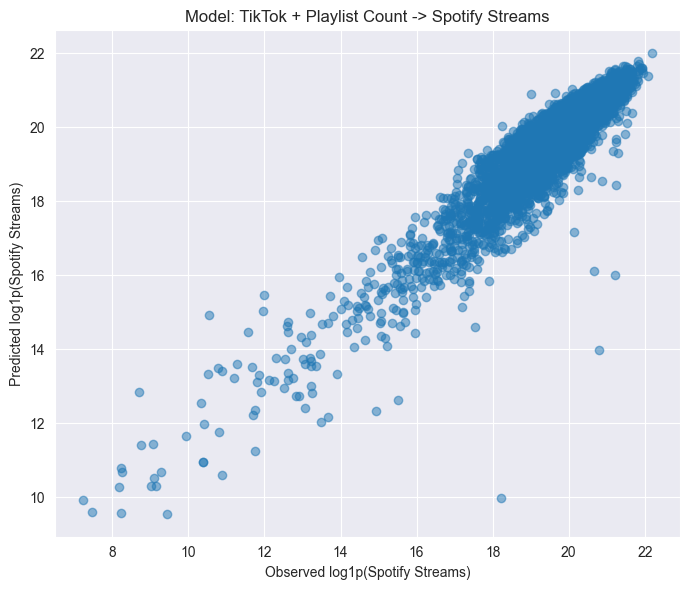

In [270]:
y_pred = model2.predict(X)
plt.figure(figsize=(7, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel("Observed log1p(Spotify Streams)")
plt.ylabel("Predicted log1p(Spotify Streams)")
plt.title("Model: TikTok + Playlist Count -> Spotify Streams")
plt.grid(True)
plt.tight_layout()
plt.show()

Adding Spotify playlist count significantly improves the model’s ability to explain streaming success. TikTok helps launch a track, but playlist exposure drives sustained growth.
Most data points lie close to the perfect-fit line, indicating strong model performance.

In [271]:
numeric_df = (df[metrics].apply(lambda s: pd.to_numeric(s.astype(str).str.replace(r"[^\d.\-]", "", regex=True), errors="coerce")))

In [272]:
numeric_df = numeric_df.dropna(how="any")
assert len(numeric_df) >= 10, "Not enough complete rows for clustering (need >=10)."

In [273]:
X = StandardScaler().fit_transform(numeric_df.values)
k = 3
kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
labels = kmeans.fit_predict(X)

In [274]:
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)
var1, var2 = pca.explained_variance_ratio_[:2] * 100

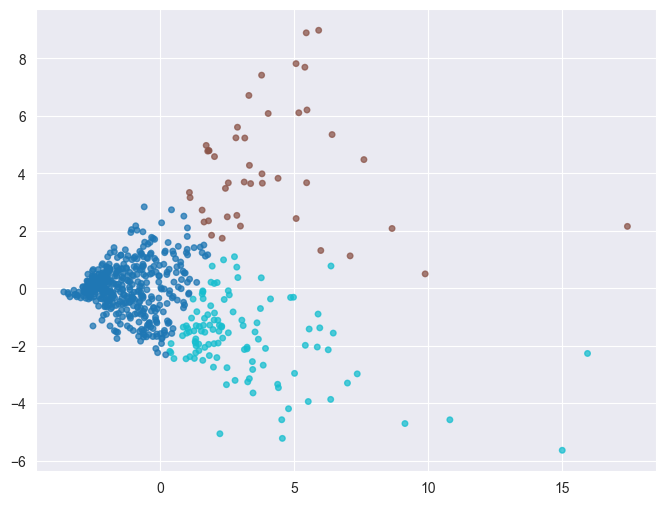

In [275]:
plt.figure(figsize=(8,6))
sc = plt.scatter(X2[:,0], X2[:,1], s=16, c=labels, cmap="tab10", alpha=0.75)

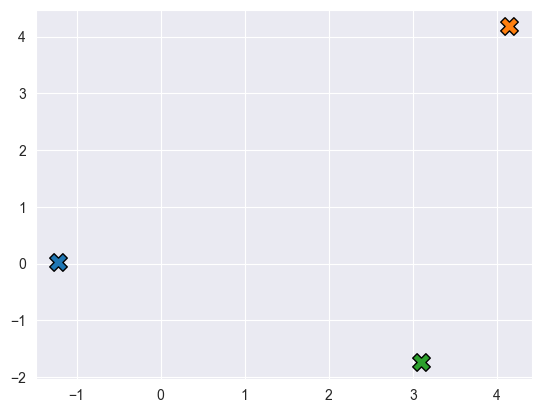

In [277]:
for i in range(k):
    cx, cy = X2[labels == i].mean(axis=0)
    plt.scatter(cx, cy, s=160, marker="X", edgecolor="k", linewidths=1.0)